# Self-Organizing Maps for Customer Cluster Analysis

## Loading data
---
We begin by downloading the [dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python) from Kaggle using the ```kagglehub``` library.

In [1]:
import kagglehub

path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

print("Path to dataset files:", path)

c:\Users\drewe\Documents\learning\customer-clustering-som\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\drewe\.cache\kagglehub\datasets\vjchoudhary7\customer-segmentation-tutorial-in-python\versions\1


We then proceed to load the dataset into a ```pandas``` dataframe.

In [2]:
import pandas as pd

df = pd.read_csv(f"{path}\Mall_Customers.csv", index_col="CustomerID")

<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\drewe\AppData\Local\Temp\ipykernel_26312\2544194061.py:3: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv(f"{path}\Mall_Customers.csv", index_col="CustomerID")


## Data exploration
---
Now that we've loaded the dataset into memory, we can examine the columns present in the dataset.

In [3]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [4]:
import matplotlib.pyplot as plt

colors = ["skyblue", "salmon", "lightgreen"]

As a first step, we look at the frequency of each gender in our dataset.

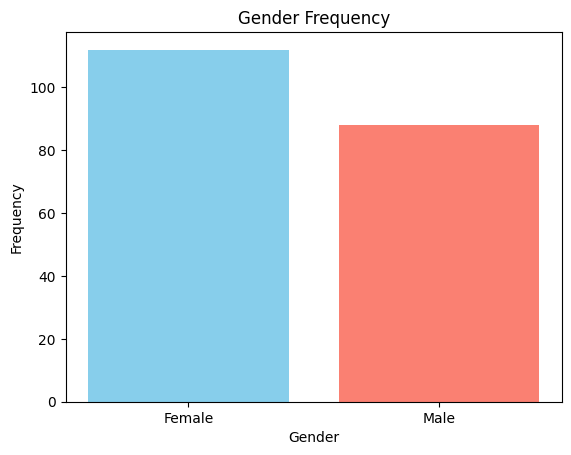

In [5]:
counts = df["Gender"].value_counts()

plt.bar(counts.index, counts.values, color=colors)

plt.title("Gender Frequency")
plt.xlabel("Gender")
plt.ylabel("Frequency")

plt.show()

We then examine the average income, spending score, and age of each gender.

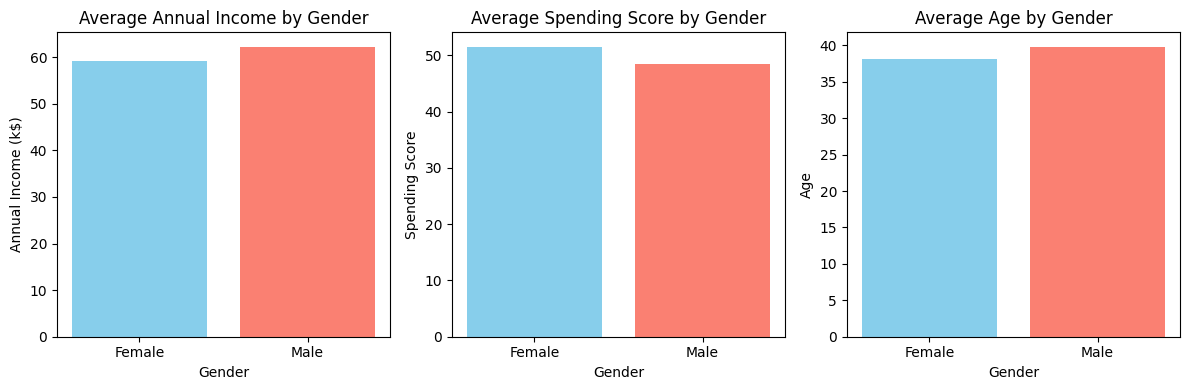

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

mean_values = df.groupby('Gender')['Annual Income (k$)'].mean()
axs[0].bar(mean_values.index, mean_values.values, color=colors)
axs[0].set_title("Average Annual Income by Gender")
axs[0].set_xlabel("Gender")
axs[0].set_ylabel("Annual Income (k$)")

mean_values = df.groupby('Gender')['Spending Score (1-100)'].mean()
axs[1].bar(mean_values.index, mean_values.values, color=colors)
axs[1].set_title("Average Spending Score by Gender")
axs[1].set_xlabel("Gender")
axs[1].set_ylabel("Spending Score")

mean_values = df.groupby('Gender')['Age'].mean()
axs[2].bar(mean_values.index, mean_values.values, color=colors)
axs[2].set_title("Average Age by Gender")
axs[2].set_xlabel("Gender")
axs[2].set_ylabel("Age")

plt.tight_layout()
plt.show()

Next, we look at the frequencies for each of the numerical features.

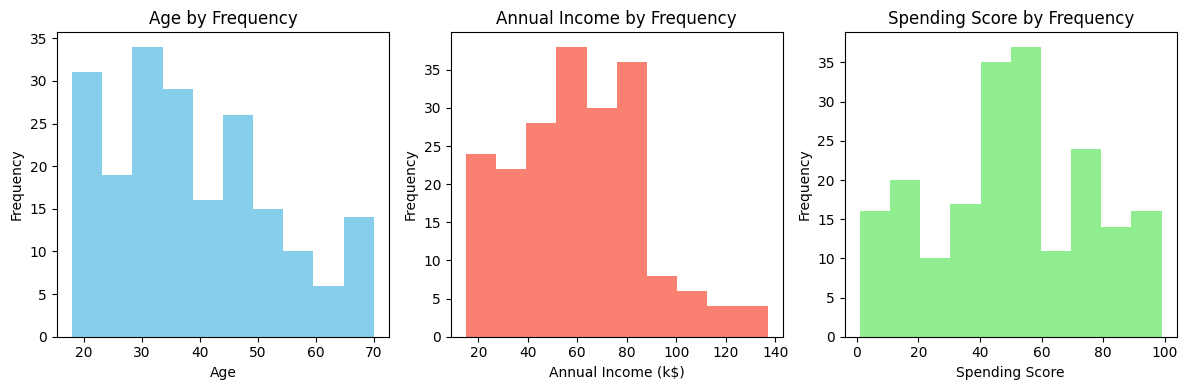

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].hist(df["Age"], color=colors[0])
axs[0].set_title("Age by Frequency")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Frequency")

axs[1].hist(df["Annual Income (k$)"], color=colors[1])
axs[1].set_title("Annual Income by Frequency")
axs[1].set_xlabel("Annual Income (k$)")
axs[1].set_ylabel("Frequency")

axs[2].hist(df["Spending Score (1-100)"], color=colors[2])
axs[2].set_title("Spending Score by Frequency")
axs[2].set_xlabel("Spending Score")
axs[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

We then visualize the relationships between each of the numerical features - no pair of features appears to be strongly correlated.

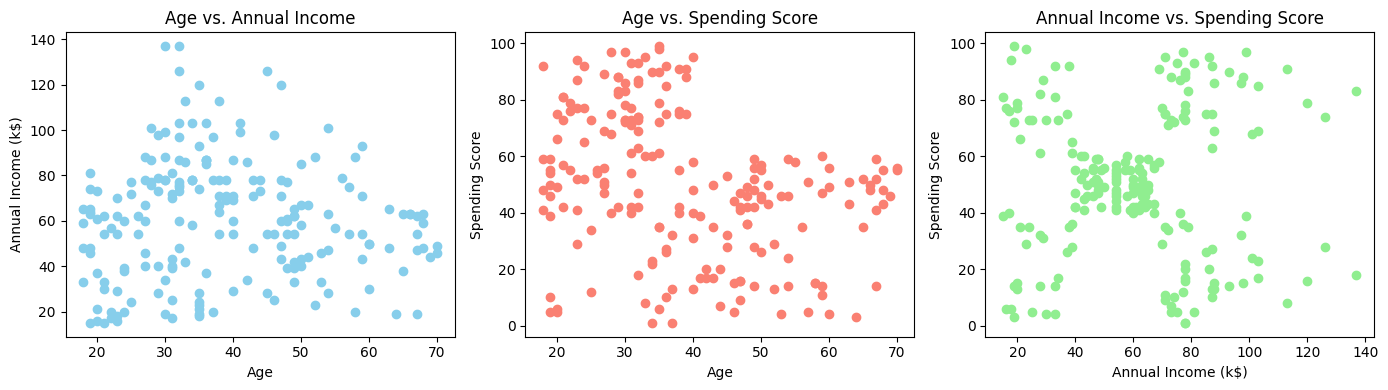

In [8]:
fig, axs = plt.subplots(1,3, figsize=(14,4))

axs[0].scatter(df["Age"], df["Annual Income (k$)"], c=colors[0])
axs[0].set_title("Age vs. Annual Income")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Annual Income (k$)")

axs[1].scatter(df["Age"], df["Spending Score (1-100)"], c=colors[1])
axs[1].set_title("Age vs. Spending Score")
axs[1].set_xlabel("Age")
axs[1].set_ylabel("Spending Score")

axs[2].scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], c=colors[2])
axs[2].set_title("Annual Income vs. Spending Score")
axs[2].set_xlabel("Annual Income (k$)")
axs[2].set_ylabel("Spending Score")

plt.tight_layout()
plt.show()

## Data preprocessing
---
Since the gender column is categorical, we use the ```get_dummies``` method in order to generate a one-hot encoding.

In [9]:
df = pd.get_dummies(df)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,False,True
2,21,15,81,False,True
3,20,16,6,True,False
4,23,16,77,True,False
5,31,17,40,True,False


We separate out the numerical columns and standardize them - this is standard practice.

In [10]:
numerical_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

In [11]:
import numpy as np

df[numerical_cols] = (df[numerical_cols] - np.mean(df[numerical_cols], axis=0)) / np.std(df[numerical_cols], axis=0)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,-1.424569,-1.738999,-0.434801,False,True
2,-1.281035,-1.738999,1.195704,False,True
3,-1.352802,-1.700830,-1.715913,True,False
4,-1.137502,-1.700830,1.040418,True,False
5,-0.563369,-1.662660,-0.395980,True,False


We then convert the dataframe into a ```numpy``` array, which is compatible with the ```minisom``` library. 

In [12]:
df = df.to_numpy().astype(np.float64)
df[:5]

array([[-1.42456879, -1.73899919, -0.43480148,  0.        ,  1.        ],
       [-1.28103541, -1.73899919,  1.19570407,  0.        ,  1.        ],
       [-1.3528021 , -1.70082976, -1.71591298,  1.        ,  0.        ],
       [-1.13750203, -1.70082976,  1.04041783,  1.        ,  0.        ],
       [-0.56336851, -1.66266033, -0.39597992,  1.        ,  0.        ]])

## Clustering
---
We define the hyperparameters for the self-organizing map (SOM).

In [13]:
map_shape = (1, 3)
shape = df.shape[1]

We then create a new SOM object using the hyperparameters we defined.

In [14]:
from minisom import MiniSom

map = MiniSom(map_shape[0], map_shape[1], shape, sigma=1, neighborhood_function="gaussian")

We then train the SOM using our dataset. We run the training process for 750 iterations.

In [15]:
map.train_batch(df, num_iteration=750, verbose=True)

 [ 750 / 750 ] 100% - 0:00:00 left 
 quantization error: 1.4839185386694347


Finally, we get the winning coordinates for each neuron in the SOM.

In [16]:
winners = np.array([map.winner(x) for x in df]).T

In [17]:
cluster_index = np.ravel_multi_index(winners, map_shape).T
cluster_index = cluster_index[:, np.newaxis]

## Dimensionality reduction
---
In order to visualize our results, we use the the UMAP algorithm (implemented by the ```umap``` library) to project our data points to a 2D space.

In [18]:
import umap

reduce_map = umap.UMAP(n_neighbors=50)
embeddings = reduce_map.fit_transform(df)

c:\Users\drewe\Documents\learning\customer-clustering-som\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


After obtaining an embedding for each data point, we append the index of the winning neuron from the SOM.

In [19]:
emb = np.append(embeddings, cluster_index, axis=-1)
emb[:5]

array([[ 6.66426849, -1.30968308,  1.        ],
       [ 6.13448048, -1.32995284,  0.        ],
       [ 4.92449093, -4.06039619,  1.        ],
       [ 5.48226833, -1.59048653,  0.        ],
       [ 4.84095049, -3.58154297,  1.        ]])

We also obtain an 2D embedding for each neuron (weight) in the SOM.

In [20]:
weight_embeddings = reduce_map.transform(map.get_weights()[0])
weight_embeddings[:5]

c:\Users\drewe\Documents\learning\customer-clustering-som\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([[ 3.7692177 ,  0.77633137],
       [ 6.652549  , -3.7348516 ],
       [ 2.4244506 , -5.368976  ]], dtype=float32)

## Results
---
Finally, we display the result of the clustering process: each cluster is represented by a different color (each of which is labelled in the legend), and each 'x' represents the position of a neuron.

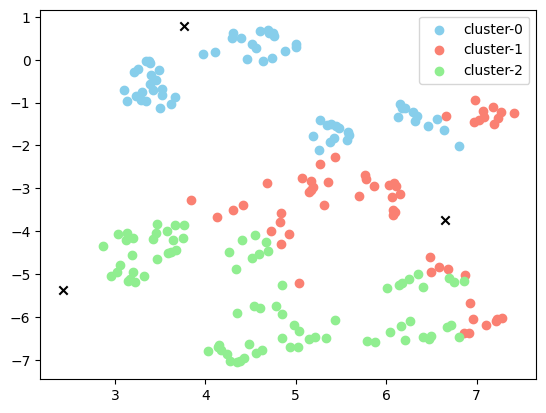

In [21]:
import matplotlib.pyplot as plt

for c in np.unique(cluster_index):
    plt.scatter(emb[emb[:, 2] == c, 0], emb[emb[:, 2] == c, 1], label=f"cluster-{c}", c=colors[c])

for c in weight_embeddings:
    plt.scatter(c[0], c[1], marker='x', color='k')

plt.legend();